# New Section

### 1. Import Library

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from torchvision.models import efficientnet_b0
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 2. Load Dataset



In [57]:
# Load dataset
train_data = pd.read_csv('/content/data/balanced_emnist_subset.csv', header=None)
test_data = pd.read_csv('/content/data/balanced_emnist_test_subset.csv', header=None)

### 3. Pemisahan Fitur dan Label

In [58]:
# Tetapkan kolom pertama sebagai label
x_train = train_data.iloc[:, 1:].values  # Semua kolom kecuali yang pertama
y_train = train_data.iloc[:, 0].values   # Kolom pertama sebagai label

x_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

print("Shape of X_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of X_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (988, 784)
Shape of y_train: (988,)
Shape of X_test: (988, 784)
Shape of y_test: (988,)


### 4. Reshape data

Reshaped X_train: (988, 1, 28, 28)
Reshaped X_test: (988, 1, 28, 28)


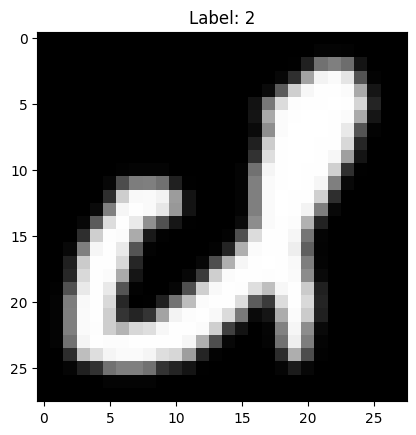

In [59]:
# Reshape dan normalisasi data
x_train = x_train.reshape((-1, 1, 28, 28)) / 255.0
x_test = x_test.reshape((-1, 1, 28, 28)) / 255.0

print("Reshaped X_train:", x_train.shape)
print("Reshaped X_test:", x_test.shape)

# Menampilkan gambar
x_train_show = x_train.reshape((-1, 28, 28))
ex_image = 60
plt.imshow(x_train_show[ex_image], cmap='gray')
plt.title(f'Label: {y_train[ex_image]}')
plt.show()

### 5. Konversi ke Tensor


In [60]:
# Konversi ke tensor
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

### 6. Data Loader

In [61]:
# Buat DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 7. Load Pre-trained Model Efficient Net

In [69]:
# Load EfficientNet dengan pretrained weights
efficientnet = efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 8. Modifikasi Model

In [70]:
# Modifikasi input layer agar menerima grayscale (1 channel)
efficientnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

In [71]:
# Modifikasi output layer agar sesuai dengan jumlah kelas
num_classes = len(np.unique(y_train))
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)
efficientnet = efficientnet.to(device)

### 9. Freeze Layer

In [72]:
# Freeze layer awal (3 blok pertama)
for param in efficientnet.features[:3].parameters():
    param.requires_grad = False

In [73]:
print(efficientnet)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 10. Optimizer dan Loss Function

In [74]:
# Optimizer hanya untuk layer yang tidak di-freeze
optimizer = optim.Adam(filter(lambda p: p.requires_grad, efficientnet.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

### 11. Training

In [75]:
# Training model
num_epochs = 100
for epoch in range(num_epochs):
    efficientnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Menghitung akurasi
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Menghitung akurasi per epoch
    epoch_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validasi setelah setiap epoch
    efficientnet.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    print(f"Validation Accuracy after Epoch [{epoch + 1}/{num_epochs}]: {val_accuracy:.4f}")

Epoch [1/100], Loss: 3.8460, Accuracy: 0.0567
Validation Accuracy after Epoch [1/100]: 0.0202
Epoch [2/100], Loss: 3.0035, Accuracy: 0.2449
Validation Accuracy after Epoch [2/100]: 0.1093
Epoch [3/100], Loss: 2.2675, Accuracy: 0.3968
Validation Accuracy after Epoch [3/100]: 0.3077
Epoch [4/100], Loss: 1.7741, Accuracy: 0.4909
Validation Accuracy after Epoch [4/100]: 0.3785
Epoch [5/100], Loss: 1.3619, Accuracy: 0.6154
Validation Accuracy after Epoch [5/100]: 0.4099
Epoch [6/100], Loss: 1.0159, Accuracy: 0.7075
Validation Accuracy after Epoch [6/100]: 0.4140
Epoch [7/100], Loss: 0.8495, Accuracy: 0.7379
Validation Accuracy after Epoch [7/100]: 0.4372
Epoch [8/100], Loss: 0.6880, Accuracy: 0.7844
Validation Accuracy after Epoch [8/100]: 0.4656
Epoch [9/100], Loss: 0.5476, Accuracy: 0.8259
Validation Accuracy after Epoch [9/100]: 0.4555
Epoch [10/100], Loss: 0.4728, Accuracy: 0.8573
Validation Accuracy after Epoch [10/100]: 0.4889
Epoch [11/100], Loss: 0.4091, Accuracy: 0.8745
Validation 

### 12. Evaluasi

Final Accuracy: 0.5810
Final Precision: 0.6152
Final F1-score: 0.5714


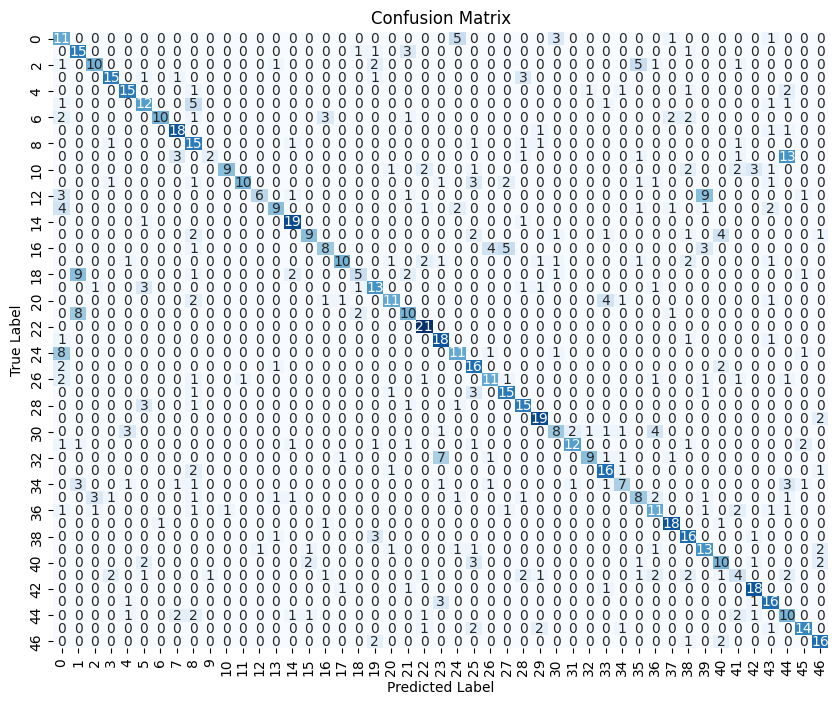

In [76]:
# Evaluasi akhir menggunakan test set
efficientnet.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final Precision: {precision:.4f}")
print(f"Final F1-score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 13. Tampilkan Preview

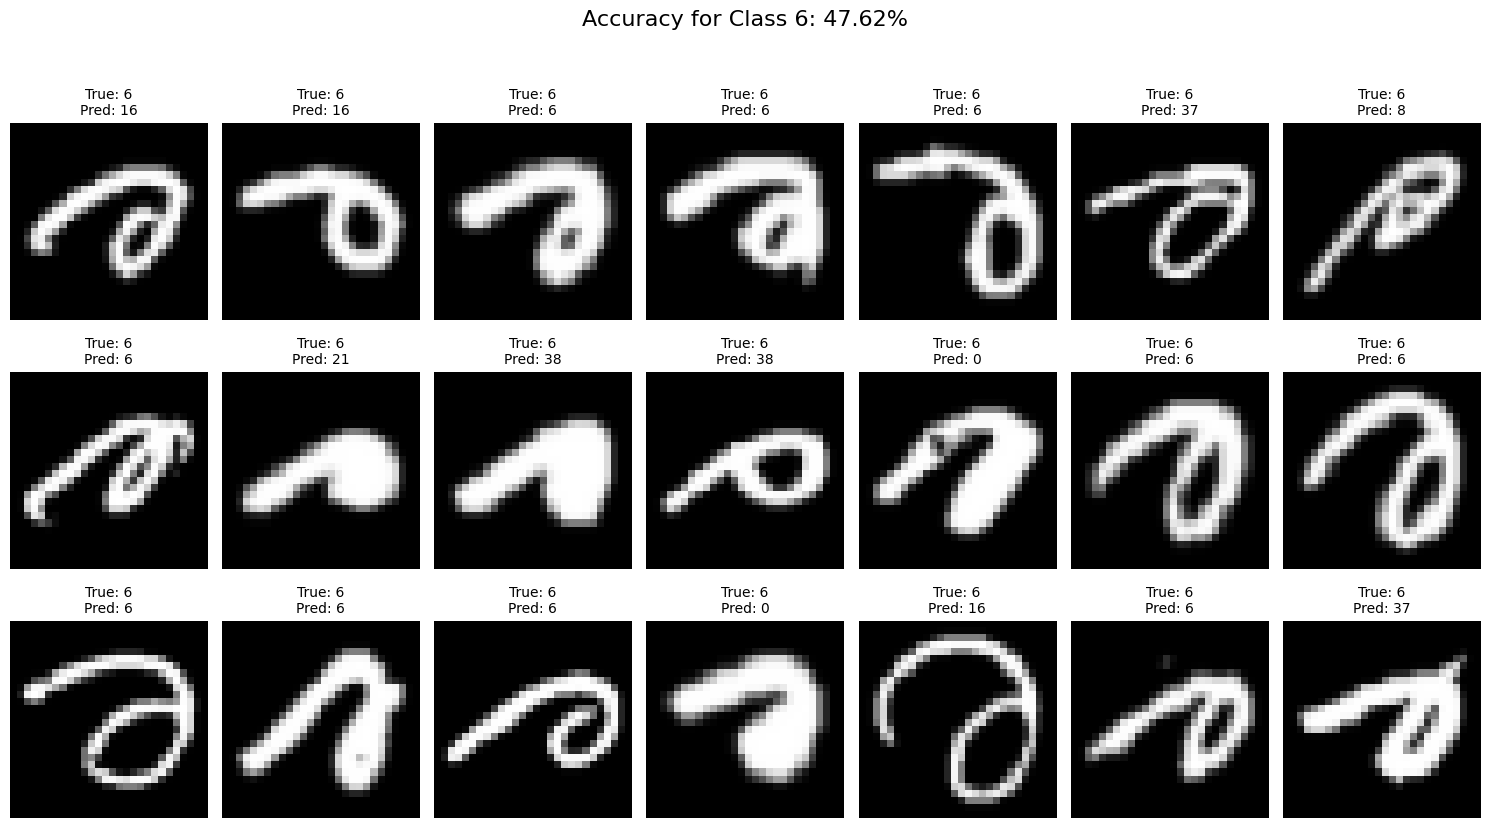

In [78]:
# Import library tambahan jika diperlukan
import random

# Pilih kelas target
target_class = 6  # Misalnya, kelas target yang ingin Anda periksa

# Ambil indeks untuk kelas target di `y_true`
indices_for_target_class = [i for i, label in enumerate(y_true) if label == target_class]

# Tentukan jumlah gambar yang ingin ditampilkan
num_samples_to_show = 21
selected_indices = random.sample(indices_for_target_class, min(num_samples_to_show, len(indices_for_target_class)))

# Hitung akurasi untuk kelas target
def calculate_accuracy(y_true, y_pred, target_class):
    correct_predictions = sum((y_pred[i] == y_true[i]) for i in range(len(y_true)) if y_true[i] == target_class)
    total_predictions = sum(1 for label in y_true if label == target_class)

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

accuracy = calculate_accuracy(y_true, y_pred, target_class)

# Tampilkan gambar dan prediksi
num_cols = 7
num_rows = (num_samples_to_show + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
axes = axes.flatten()

# Ubah `x_test` menjadi array 2D untuk visualisasi
x_test_visual = x_test.reshape(-1, 28, 28)

for i, index in enumerate(selected_indices):
    ax = axes[i]
    image = x_test_visual[index]  # Ambil gambar berdasarkan indeks
    true_label = y_true[index]
    predicted_label = y_pred[index]

    ax.imshow(image, cmap='gray')  # Tampilkan gambar grayscale
    ax.axis('off')
    ax.set_title(f'True: {true_label}\nPred: {predicted_label}', fontsize=10)

# Sembunyikan subplot yang tidak digunakan
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Tambahkan judul untuk akurasi
plt.suptitle(f'Accuracy for Class {target_class}: {accuracy * 100:.2f}%', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Atur layout agar tidak bertabrakan dengan suptitle
plt.show()

### 14. Evaluasi LOOCV

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LOOCV Accuracy: 0.0263
LOOCV Precision: 0.0304
LOOCV F1-score: 0.0234


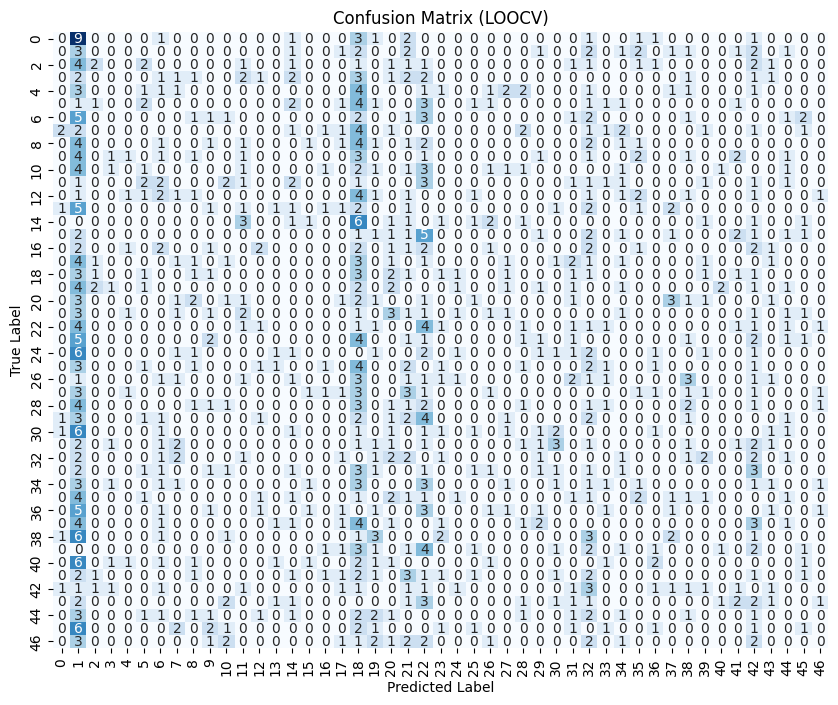

In [79]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

# Dataset untuk LOOCV
X = x_train_tensor.numpy()
y = y_train_tensor.numpy()

# Setup Leave-One-Out Cross-Validation
loo = LeaveOneOut()
y_true_loo = []
y_pred_loo = []

# Iterasi LOOCV
for train_index, test_index in loo.split(X):
    # Data pelatihan dan validasi
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    # Konversi ke tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

    # DataLoader untuk pelatihan
    train_dataset_loo = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader_loo = DataLoader(train_dataset_loo, batch_size=batch_size, shuffle=True)

    # Clone model untuk tiap iterasi
    model = efficientnet_b0(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)

    # Optimizer dan loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Latih model
    model.train()
    for _ in range(1):  # Hanya 1 epoch untuk LOOCV
        for images, labels in train_loader_loo:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluasi pada data validasi
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor)
        _, predicted = torch.max(outputs, 1)
        y_true_loo.append(y_val[0])
        y_pred_loo.append(predicted.cpu().item())

# Evaluasi akhir
accuracy_loo = accuracy_score(y_true_loo, y_pred_loo)
precision_loo = precision_score(y_true_loo, y_pred_loo, average='macro')
f1_loo = f1_score(y_true_loo, y_pred_loo, average='macro')

print(f"LOOCV Accuracy: {accuracy_loo:.4f}")
print(f"LOOCV Precision: {precision_loo:.4f}")
print(f"LOOCV F1-score: {f1_loo:.4f}")

# Confusion Matrix untuk LOOCV
conf_matrix_loo = confusion_matrix(y_true_loo, y_pred_loo)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_loo, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title("Confusion Matrix (LOOCV)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
